In [24]:
import json
import os
import torch
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [102]:
def read_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

In [115]:
# Define the filename
filename = "Zeyu_ECG.json"

# Read the JSON file
data = read_json_file(filename)

# Initialize lists to store integrated segments (X) and labels (y)
X = []
y = []

# Extract integrated segments and labels from the data
for segment_data in data:
    integrated_segment = segment_data["integrated_segment"]
    label = segment_data["label"]
    X.append(integrated_segment)
    y.append(label)

In [89]:
max_length = max(len(segment) for segment in X)
print(max_length)

920


In [104]:
max_length = 1000

In [116]:
padded_X = []
for segment in X:
    pad_length = max_length - len(segment)
    padded_segment = np.pad(segment, (0, pad_length), mode='edge')  # Padding with the last observed value
    padded_X.append(padded_segment)
# Convert padded_X to a numpy array
padded_X = np.array(padded_X)

# Print the shape of padded_X to verify
print("Shape of padded_X:", padded_X.shape)

Shape of padded_X: (2561, 1000)


In [117]:
# from sklearn.model_selection import train_test_split
X_test = torch.tensor(padded_X, dtype=torch.float32).to(device)
y_test = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

In [118]:
val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [119]:
class FCClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FCClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)
        self.non_lin = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.non_lin(self.fc1(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc2(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [109]:
model = FCClassifier(input_dim=max_length).to(device)

In [110]:
model.load_state_dict(torch.load('Siddharth_fc1000.pth', map_location=device))

<All keys matched successfully>

In [111]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([1.4180, 0.7723], device='cuda:0')


In [120]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
# train_accuracies = []
val_accuracies = []
# train_losses = []
val_losses = []
# train_f1s = []
val_f1s = []

In [121]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def val(model, val_loader, criterion, epochs=20):

    for epoch in range(epochs):
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_onehot = F.one_hot(labels.long(), num_classes=2).squeeze(1).type(torch.float32)
                loss = criterion(outputs, labels_onehot)
                running_val_loss += loss.item()

                # Compute validation accuracy
                prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
                correct_val += (prediction == expected).sum().item()
                total_val += labels.size(0)
                val_predictions.extend(prediction)
                val_labels.extend(expected)
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_score = f1_score(val_labels, val_predictions)
        val_f1s.append(val_f1_score)
        

        val_conf_matrix = confusion_matrix(val_labels, val_predictions)

        print("\nValidation Confusion Matrix:")
        plot_confusion_matrix(val_conf_matrix, title="Transfer Confusion Matrix")

        print(f"Epoch {epoch+1}/{epochs}, "
      f"Val Loss: {val_loss:.4f}, "
      f"Val Accuracy: {val_accuracy:.4f}, "
      f"Val F1 Score: {val_f1_score:.4f}")



Validation Confusion Matrix:


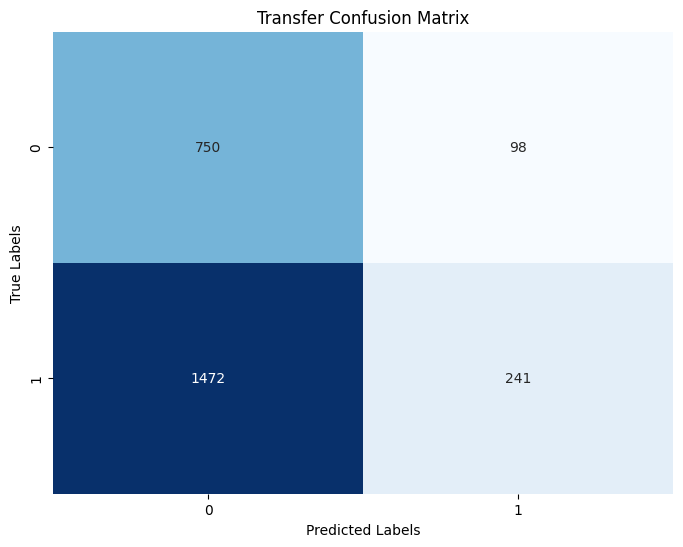

Epoch 1/1, Val Loss: 0.6910, Val Accuracy: 0.3870, Val F1 Score: 0.2349


In [123]:
val(model, val_loader, criterion, epochs=1)

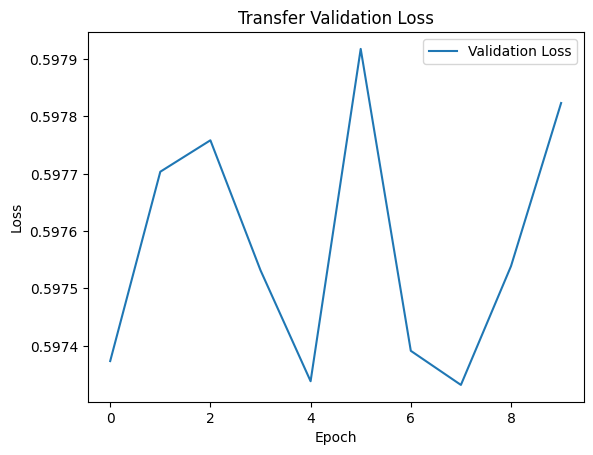

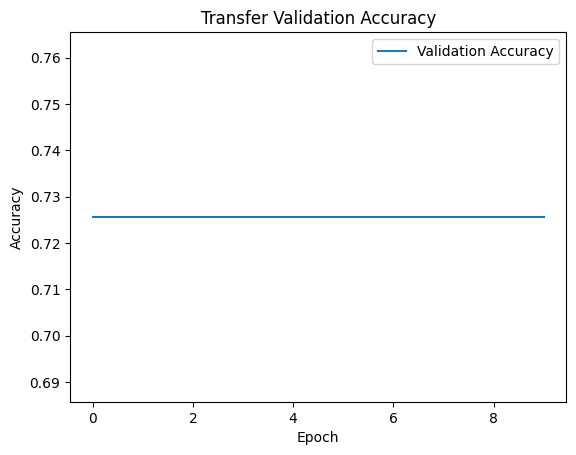

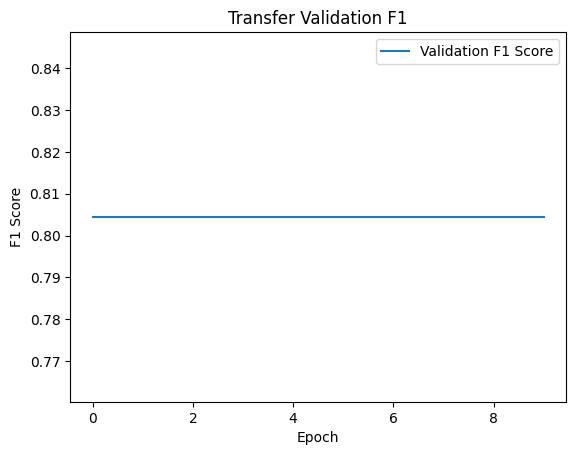

In [40]:
import matplotlib.pyplot as plt

def plot_loss(val_losses):
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Transfer Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Transfer Validation Accuracy')
    plt.legend()
    plt.show()

def plot_f1s(val_f1s):
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Transfer Validation F1')
    plt.legend()
    plt.show()

# Assuming train_losses, train_accuracies, val_losses, val_accuracies are available
plot_loss(val_losses)
plot_accuracy(val_accuracies)
plot_f1s(val_f1s)

In [23]:
torch.save(model.state_dict(), 'Zeyu_fc1000.pth')